In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image, ImageOps
import pandas as pd
import csv

import torch
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from itertools import groupby

from tqdm import tqdm

torch.manual_seed(42)

In [2]:
class TRDataset(torch.utils.data.Dataset):
    CHARS = '0123456789abcdefghijklmnopqrstuvwxyz'
    CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}
    LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}
    
    def __init__(self, root_dir=None, labels=None, img_height=32, img_width=100):
        self.root_dir = root_dir
        self.labels = labels
        self.img_height = img_height
        self.img_width = img_width

        self.data = self.read_labels()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = os.path.join(self.root_dir, 'images', img_name + '.jpg')
        
        try:
            image = Image.open(img_path).convert('L')  # grey-scale
        except IOError:
            print('Corrupted image for %d' % idx)
            return self[idx + 1]
        
        image = image.resize((self.img_width, self.img_height), resample=Image.BILINEAR)
        image = np.array(image)
        image = image.reshape((1, self.img_height, self.img_width))
        image = (image / 127.5) - 1.0
        image = torch.FloatTensor(image)
        
        if label:
            target = [self.CHAR2LABEL[c] for c in label]
            target_length = [len(target)]

            target = torch.LongTensor(target)
            target_length = torch.LongTensor(target_length)
            return image, target, target_length
        else:
            return image

    def read_labels(self):
        data = []
        with open(os.path.join(self.root_dir, self.labels), "r") as file:
            csv_reader = csv.reader(file)
            next(csv_reader)  # Skip the header if there is one
            for row in csv_reader:
                img_name = row[0]
                label = row[1].lower()
                data.append((img_name, label))
        return data
    
def collate_batch(batch):
    images, targets, target_lengths = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    target_lengths = torch.cat(target_lengths, 0)
    return images, targets, target_lengths

In [3]:
img_height, img_width = 32,100

In [4]:
dataset = TRDataset(root_dir="datasets/cropped_text",
                    labels="labels.csv",
                    img_width=img_width,
                    img_height=img_height)

In [5]:
train_size = int(0.98 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [6]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [7]:
class CRNN(nn.Module):
    def __init__(self, img_channel, img_height, img_width, num_class, map_to_seq=64, rnn_hidden=256):
        super(CRNN, self).__init__()
        self.cnn, (output_channel, output_height, output_width) = self._cnn_backbone(img_channel, img_height, img_width)
        self.map_to_seq = nn.Linear(output_channel * output_height, map_to_seq)
        self.rnn1 = nn.LSTM(map_to_seq, rnn_hidden, bidirectional=True)
        self.rnn2 = nn.LSTM(2 * rnn_hidden, rnn_hidden, bidirectional=True)
        self.dense = nn.Linear(2 * rnn_hidden, num_class)

    def _cnn_backbone(self, img_channel, img_height, img_width):
        assert img_height % 16 == 0
        assert img_width % 4 == 0

        channels = [img_channel, 64, 128, 256, 256, 512, 512, 512]
        kernel_sizes = [3, 3, 3, 3, 3, 3, 2]
        strides = [1, 1, 1, 1, 1, 1, 1]
        paddings = [1, 1, 1, 1, 1, 1, 0]

        cnn = nn.Sequential()

        def conv_relu(i, batch_norm=False):
            # shape of input: (batch, input_channel, height, width)
            input_channel = channels[i]
            output_channel = channels[i+1]

            cnn.add_module(f'conv{i}', nn.Conv2d(input_channel, output_channel, kernel_sizes[i], strides[i], paddings[i]))

            if batch_norm:
                cnn.add_module(f'batchnorm{i}', nn.BatchNorm2d(output_channel))

            relu = nn.ReLU(inplace=True)
            cnn.add_module(f'relu{i}', relu)

        # size of image: (channel, height, width) = (img_channel, img_height, img_width)
        conv_relu(0)
        cnn.add_module('pooling0', nn.MaxPool2d(kernel_size=2, stride=2)) # (64, img_height // 2, img_width // 2)
        
        conv_relu(1)
        cnn.add_module('pooling1', nn.MaxPool2d(kernel_size=2, stride=2)) # (128, img_height // 4, img_width // 4)
        
        conv_relu(2)
        conv_relu(3)
        cnn.add_module('pooling2', nn.MaxPool2d(kernel_size=(2, 1)))  # (256, img_height // 8, img_width // 4)
        
        conv_relu(4, batch_norm=True)
        conv_relu(5, batch_norm=True)
        cnn.add_module('pooling3',nn.MaxPool2d(kernel_size=(2, 1)))  # (512, img_height // 16, img_width // 4)
        
        conv_relu(6)  # (512, img_height // 16 - 1, img_width // 4 - 1)
        output_channel, output_height, output_width = channels[-1], img_height // 16 - 1, img_width // 4 - 1
        
        return cnn, (output_channel, output_height, output_width)

    def forward(self, images):
        # shape of images: (batch, channel, height, width)

        conv = self.cnn(images)
        batch, channel, height, width = conv.size()

        conv = conv.view(batch, channel * height, width)
        conv = conv.permute(2, 0, 1)  # (width, batch, feature)
        seq = self.map_to_seq(conv)

        recurrent, _ = self.rnn1(seq)
        recurrent, _ = self.rnn2(recurrent)

        output = self.dense(recurrent)
        return output  # shape: (seq_len, batch, num_class)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:
num_class = len(TRDataset.LABEL2CHAR) + 1

In [17]:
crnn = CRNN(1, img_height, img_width, num_class,
                map_to_seq=64,
                rnn_hidden=256)

In [18]:
reload_checkpoint = 'checkpoints/crnn_100k_5.04.pt'

if reload_checkpoint:
    crnn.load_state_dict(torch.load(reload_checkpoint, map_location=device))
crnn.to(device)

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace=True)
    (conv5): Conv2d(512, 512, 

In [19]:
criterion = nn.CTCLoss(reduction='sum', zero_infinity=True)
optimizer = torch.optim.Adam(crnn.parameters(), lr=0.0005)

In [20]:
def train_batch(crnn, data, optimizer, criterion, device):
    crnn.train()
    images, targets, target_lengths = [d.to(device) for d in data]

    logits = crnn(images)
    log_probs = torch.nn.functional.log_softmax(logits, dim=2)

    batch_size = images.size(0)
    input_lengths = torch.LongTensor([logits.size(0)] * batch_size)
    target_lengths = torch.flatten(target_lengths)

    loss = criterion(log_probs, targets, input_lengths, target_lengths)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(crnn.parameters(), 5) # gradient clipping with 5
    optimizer.step()
    return loss.item()

def _reconstruct(labels, blank=0):
    new_labels = []
    # merge same labels
    previous = None
    for l in labels:
        if l != previous:
            new_labels.append(l)
            previous = l
    # delete blank
    new_labels = [l for l in new_labels if l != blank]

    return new_labels

def greedy_decode(emission_log_prob, blank=0):
    labels = np.argmax(emission_log_prob, axis=-1)
    labels = _reconstruct(labels, blank=blank)
    return labels

def ctc_decode(log_probs, label2char=None, blank=0):
    emission_log_probs = np.transpose(log_probs.cpu().numpy(), (1, 0, 2))
    
    decoded_list = []
    for emission_log_prob in emission_log_probs:
        decoded = greedy_decode(emission_log_prob, blank=blank)
        if label2char:
            decoded = [label2char[l] for l in decoded]
        decoded_list.append(decoded)
    return decoded_list

def evaluate(crnn, dataloader, criterion, max_iter=None):
    crnn.eval()

    tot_count = 0
    tot_loss = 0
    tot_correct = 0
    wrong_cases = []

    pbar_total = max_iter if max_iter else len(dataloader)
    pbar = tqdm(total=pbar_total, desc="Evaluate")

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            if max_iter and i >= max_iter:
                break
            device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

            images, targets, target_lengths = [d.to(device) for d in data]

            logits = crnn(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            batch_size = images.size(0)
            input_lengths = torch.LongTensor([logits.size(0)] * batch_size)

            loss = criterion(log_probs, targets, input_lengths, target_lengths)

            preds = ctc_decode(log_probs)
            reals = targets.cpu().numpy().tolist()
            target_lengths = target_lengths.cpu().numpy().tolist()

            tot_count += batch_size
            tot_loss += loss.item()
            target_length_counter = 0
            for pred, target_length in zip(preds, target_lengths):
                real = reals[target_length_counter:target_length_counter + target_length]
                target_length_counter += target_length
                if pred == real:
                    tot_correct += 1
                else:
                    wrong_cases.append((real, pred))

            pbar.update(1)
        pbar.close()

    evaluation = {
        'loss': tot_loss / tot_count,
        'acc': tot_correct / tot_count,
        'wrong_cases': wrong_cases
    }
    return evaluation

def predict(crnn, dataloader, label2char):
    crnn.eval()
    pbar = tqdm(total=len(dataloader), desc="Predict")

    all_preds = []
    with torch.no_grad():
        for data in dataloader:
            device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

            images, targets, target_lengths = [d.to(device) for d in data]

            logits = crnn(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            preds = ctc_decode(log_probs, label2char=label2char)
            all_preds += preds

            pbar.update(1)
        pbar.close()

    return all_preds


def show_result(preds):
    print('\n===== result =====')
    for pred in preds:
        text = ''.join(pred)
        print(text)

In [21]:
evaluation = evaluate(crnn, val_loader, criterion)
print('valid_evaluation: loss={loss}, acc={acc}'.format(**evaluation))

Evaluate: 100%|██████████| 32/32 [00:03<00:00,  8.12it/s]

valid_evaluation: loss=2.236805862426758, acc=0.7795


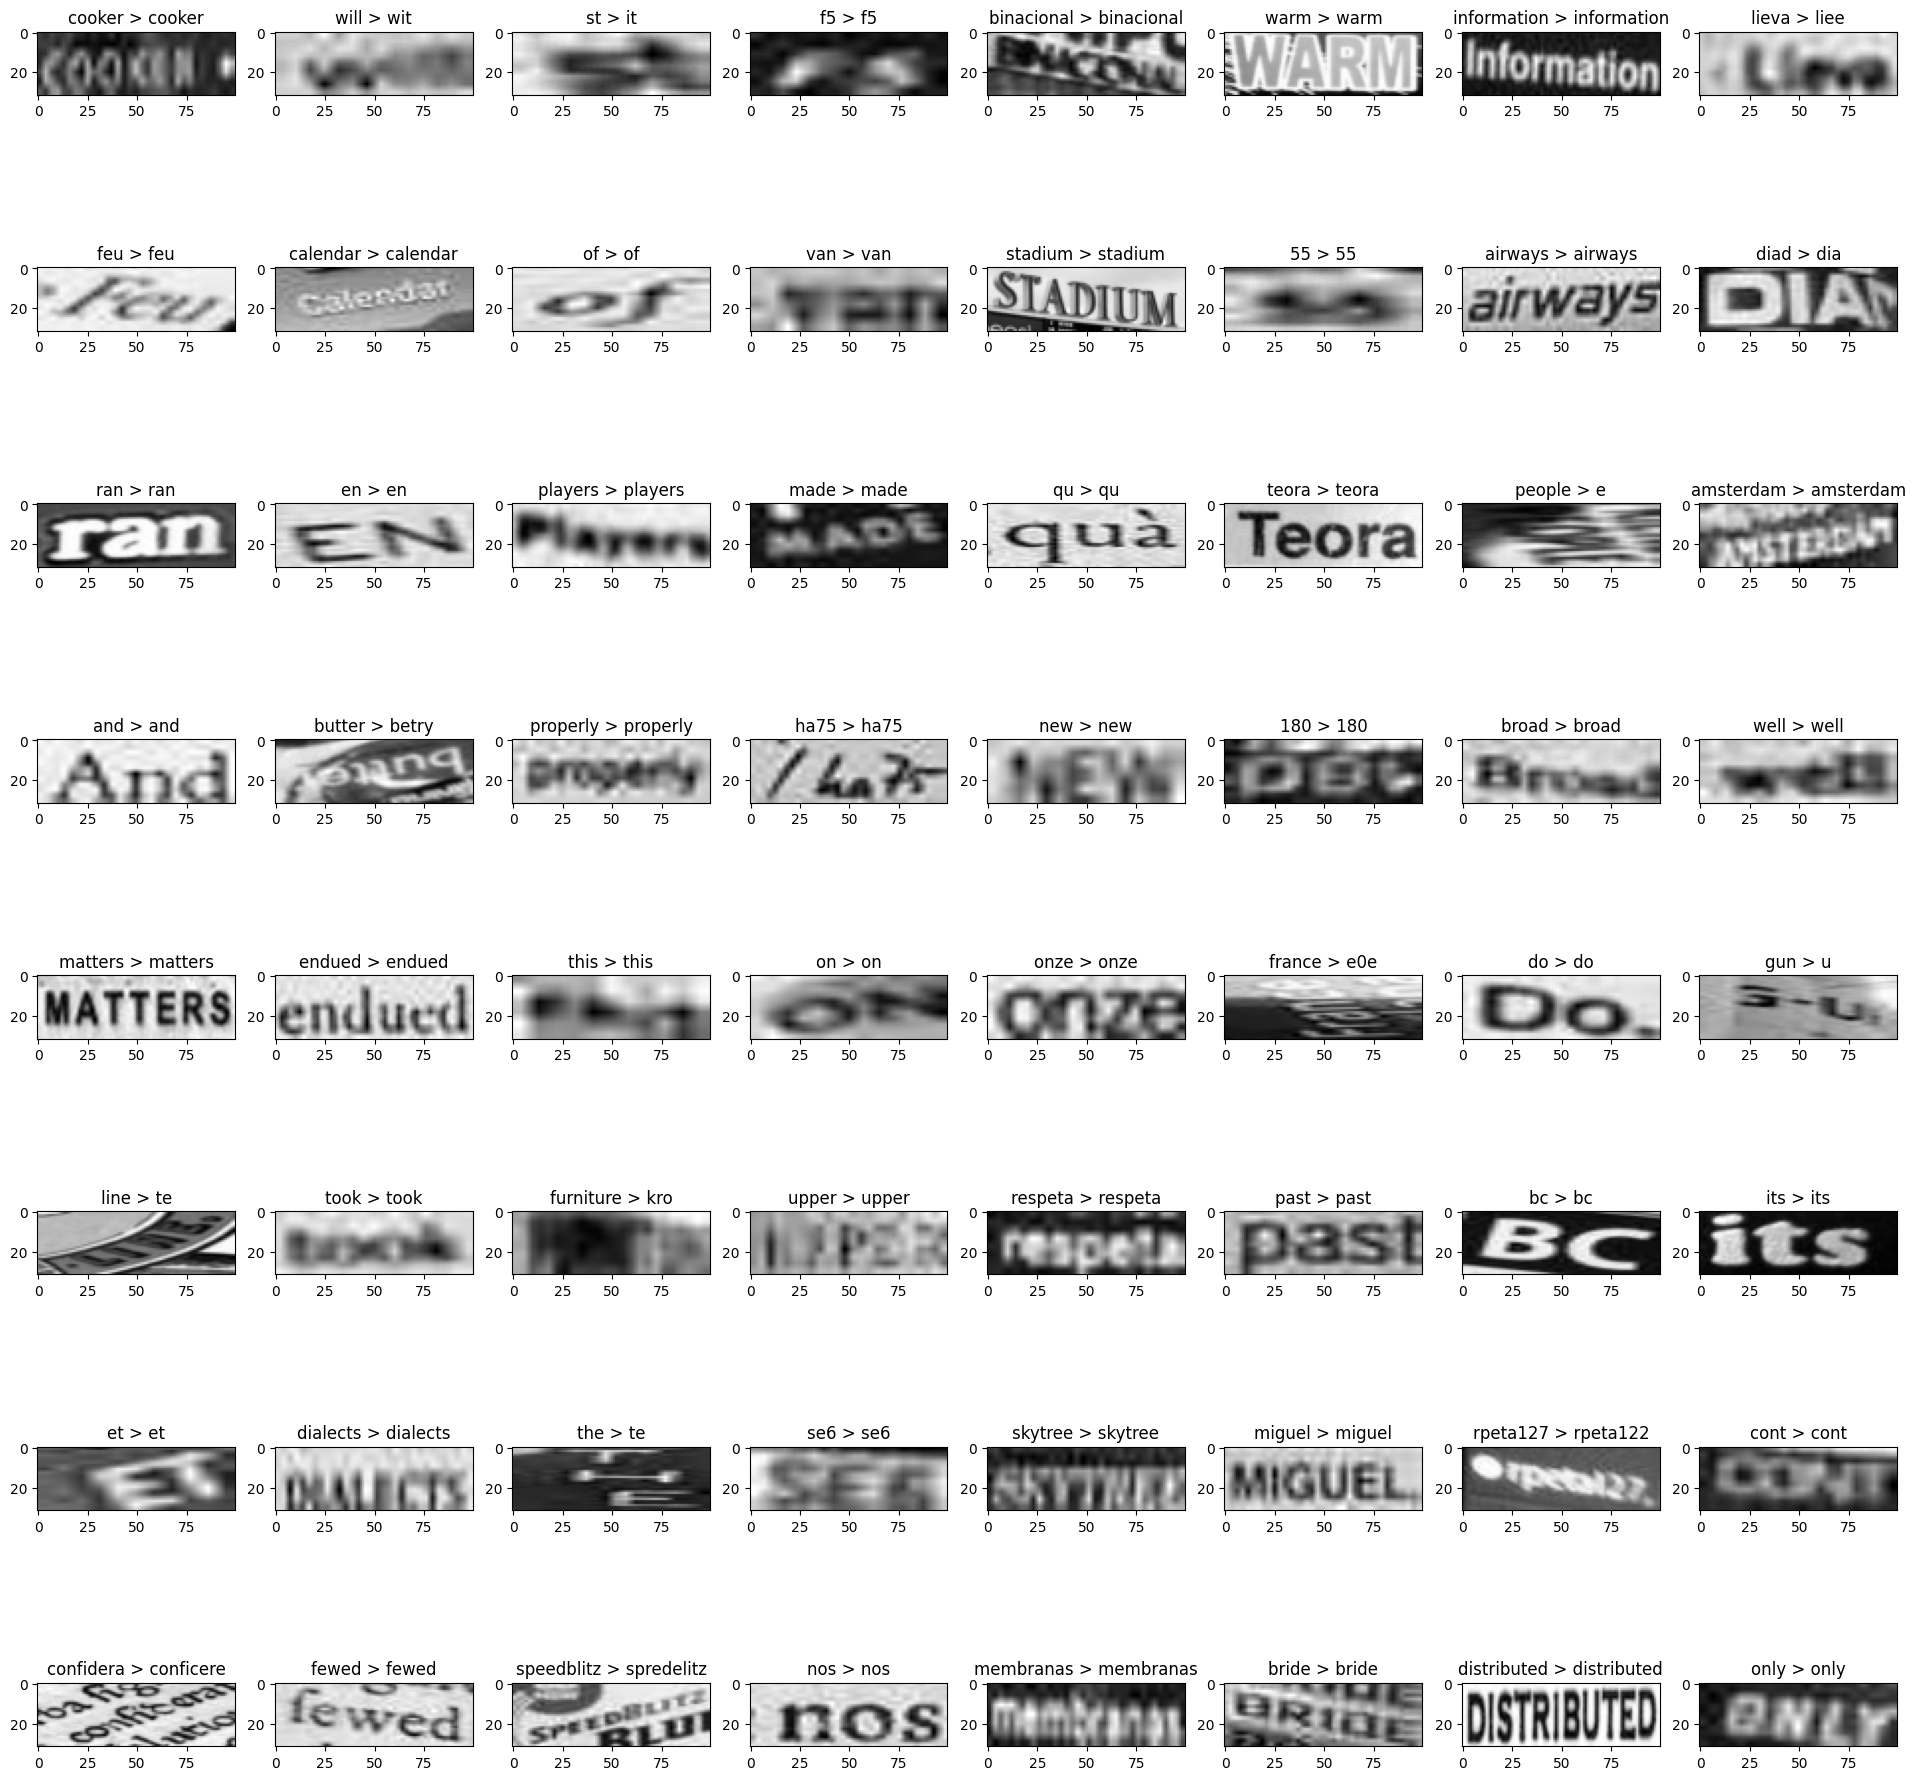

In [22]:
fig, axes = plt.subplots(8, 8, figsize=(24, 24))

crnn.eval()

label2char = TRDataset.LABEL2CHAR
with torch.no_grad():
    for i, data in enumerate(val_loader):
        device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

        images, targets, target_lengths = [d.to(device) for d in data]

        logits = crnn(images)
        log_probs = torch.nn.functional.log_softmax(logits, dim=2)

        batch_size = images.size(0)
        input_lengths = torch.LongTensor([logits.size(0)] * batch_size)

        loss = criterion(log_probs, targets, input_lengths, target_lengths)

        preds = ctc_decode(log_probs, label2char=label2char)
        reals = targets.cpu().numpy().tolist()
        target_lengths = target_lengths.cpu().numpy().tolist()

        all_preds = []
        all_reals = []
        target_length_counter = 0
        for pred, target_length in zip(preds, target_lengths):
            real = reals[target_length_counter:target_length_counter + target_length]
            real = [label2char[l] for l in real]
            pred_text, real_text = ''.join(pred), ''.join(real)
            all_preds.append(pred_text)
            all_reals.append(real_text)

            target_length_counter += target_length

        for i, img in enumerate(images.cpu().numpy()):
            axes.flatten()[i].imshow(img[0], cmap='gray')
            axes.flatten()[i].set_title(f'{all_reals[i]} > {all_preds[i]}')

        plt.show()
        break

In [ ]:
epochs = 10

train_losses = []
val_losses = []
val_accs = []
for epoch in range(1,epochs+1):
    print(f'epoch: {epoch}')
    run_train_loss = 0.
    run_train_count = 0
    
    step = 1
    for train_data in train_loader:
        loss = train_batch(crnn, train_data, optimizer, criterion, device)
        train_size = train_data[0].size(0)
        run_train_loss += loss
        run_train_count += train_size
        if step%100 == 0:
            print(f'train_batch_loss [{step}/{len(train_loader)}] : {run_train_loss/run_train_count :.2f}')
        
        step += 1
    
    train_loss = loss / train_size
    print('train_batch_loss[', epoch, ']: ', loss / train_size)
    train_losses.append(train_loss)
    
    evaluation = evaluate(crnn, val_loader, criterion)
    print('valid_evaluation[', epoch, ']: loss={}, acc={}'.format(evaluation['loss'], evaluation['acc']))
    val_losses.append(evaluation['loss'])
    val_accs.append(evaluation['acc'])

In [ ]:
evaluation = evaluate(crnn, val_loader, criterion)
print('valid_evaluation: loss={}, acc={}'.format(evaluation['loss'], evaluation['acc']))

In [ ]:
cp_path = os.path.join('checkpoints','crnn_100k_5.04.pt')
torch.save(crnn.state_dict(),cp_path)